In [1]:
from utils.body import BODY_CONNECTIONS
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

In [2]:
sns.set_style('darkgrid')

In [3]:
keypoints = np.load('keypoints_sequences.npy')
labels = np.load('labels.npy')

keypoints.shape, labels.shape

((111, 20, 34), (111,))

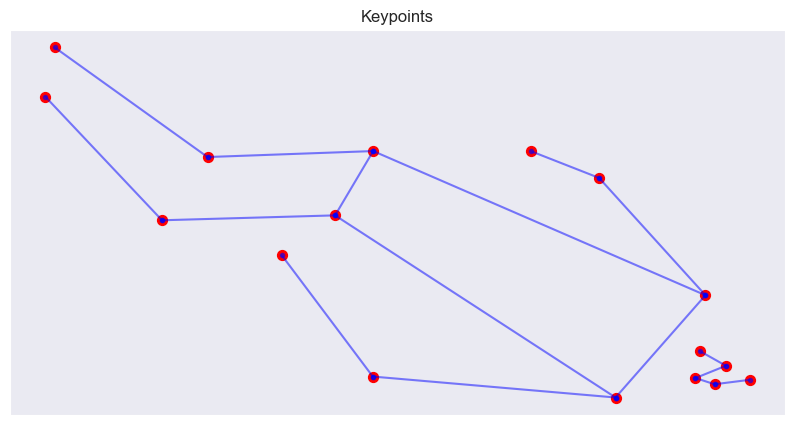

In [4]:
from utils.body import draw_skeleton

fig, axs = plt.subplots(figsize=(10, 5))

draw_skeleton(axs, keypoints[6][6].reshape(-1, 2), 'Keypoints')

In [5]:
keypoints.shape

(111, 20, 34)

In [6]:
import numpy as np
import plotly.graph_objects as go

def visualize_keypoints_sequence(keypoints, labels, sequence_idx, body_connections):
    """
    Visualiza una secuencia de keypoints como una animación.

    Args:
        keypoints (np.array): Array de keypoints con forma (num_sequences, num_frames, num_keypoints * 2).
        labels (np.array): Array de etiquetas con forma (num_sequences,).
        sequence_idx (int): Índice de la secuencia a visualizar.
        body_connections (list): Lista de tuplas que definen las conexiones entre keypoints.
    """
    num_frames = keypoints.shape[1]
    
    # Crear frames de la animación
    frames = []
    for frame_idx in range(num_frames):
        keypoints_sq = keypoints[sequence_idx][frame_idx]
        
        # Obtener coordenadas x, y
        x_vals, y_vals = keypoints_sq[::2], keypoints_sq[1::2]
        
        # Filtrar keypoints inválidos
        valid_points = [(x, y) for x, y in zip(x_vals, y_vals) if (x != 0 or y != 0)]
        if not valid_points:
            continue  # Omitir frames sin información
        
        # Generar líneas de conexión entre keypoints
        line_x, line_y = [], []
        for start, end in body_connections:
            if x_vals[start] != 0 and x_vals[end] != 0:
                line_x.extend([x_vals[start], x_vals[end], None])  # None separa segmentos
                line_y.extend([y_vals[start], y_vals[end], None])

        # Agregar frame
        frames.append(go.Frame(
            data=[
                go.Scatter(x=[p[0] for p in valid_points], y=[p[1] for p in valid_points], mode='markers', marker=dict(color='red', size=6), name="Keypoints"),
                go.Scatter(x=line_x, y=line_y, mode='lines', line=dict(color='blue', width=3), name="Connections")
            ],
            name=str(frame_idx)
        ))

    # Crear figura base con primer frame
    fig = go.Figure(
        data=[
            go.Scatter(x=[], y=[], mode='markers', marker=dict(color='red', size=6), name="Keypoints"),
            go.Scatter(x=[], y=[], mode='lines', line=dict(color='blue', width=3), name="Connections")
        ],
        layout=go.Layout(
            title=f"Animación de Keypoints - Secuencia {sequence_idx} ({labels[sequence_idx]})",
            xaxis=dict(range=[0, 1], title="X"),
            yaxis=dict(range=[1, 0], title="Y"),  # Invertido para coincidir con imagen
            updatemenus=[dict(
                type="buttons",
                showactive=True,
                buttons=[
                    dict(label="▶ Play", method="animate", args=[None, dict(frame=dict(duration=100, redraw=True))]),
                    dict(label="⏸ Pause", method="animate", args=[[None], dict(frame=dict(duration=0, redraw=False))])
                ]
            )]
        ),
        frames=frames
    )

    fig.show()
    
visualize_keypoints_sequence(keypoints, labels, 6, BODY_CONNECTIONS)

In [7]:
fall_keypoints = keypoints[labels == 1]
normal_keypoints = keypoints[labels == 0]

fall_keypoints.shape, normal_keypoints.shape

((43, 20, 34), (68, 20, 34))

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim

In [9]:
# # Aplanar las secuencias
# num_sequences, num_frames, num_keypoints = keypoints.shape
# keypoints_flattened = keypoints.reshape(num_sequences, num_frames * num_keypoints)

# print(keypoints_flattened.shape)

num_sequences_fall, num_frames_fall, num_keypoints_fall = fall_keypoints.shape
num_sequences_normal, num_frames_normal, num_keypoints_normal = normal_keypoints.shape

# Aplanar las secuencias
fall_keypoints_flattened = fall_keypoints.reshape(num_sequences_fall, num_frames_fall * num_keypoints_fall)
normal_keypoints_flattened = normal_keypoints.reshape(num_sequences_normal, num_frames_normal * num_keypoints_normal)

print(fall_keypoints_flattened.shape, normal_keypoints_flattened.shape)

(43, 680) (68, 680)


In [10]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),  # Cambiado ReLU a LeakyReLU
            nn.BatchNorm1d(hidden_dim),  # Normalización de lotes
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.2),  # Otra capa de LeakyReLU
            nn.BatchNorm1d(hidden_dim),  # Normalización de lotes
            nn.Linear(hidden_dim, latent_dim * 2)  # Salida: media y log-varianza
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(0.2),  # Cambiado ReLU a LeakyReLU
            nn.BatchNorm1d(hidden_dim),  # Normalización de lotes
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(0.2),  # Otra capa de LeakyReLU
            nn.BatchNorm1d(hidden_dim),  # Normalización de lotes
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()  # Para datos en el rango [0, 1]
        )
    
    def reparameterize(self, mu, logvar):
        """Reparameterization trick para muestrear de la distribución latente."""
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self, x):
        # Paso a través del encoder
        h = self.encoder(x)
        mu, logvar = torch.chunk(h, 2, dim=-1)  # Dividir en media y log-varianza
        
        # Muestrear del espacio latente
        z = self.reparameterize(mu, logvar)
        
        # Reconstruir los datos
        x_recon = self.decoder(z)
        
        return x_recon, mu, logvar

In [11]:
def loss_function(recon_x, x, mu, logvar):
    # Reconstruction loss (usamos MSE para datos continuos)
    # recon_loss = nn.functional.mse_loss(recon_x, x, reduction='sum')
    recon_loss = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    
    # KL divergence
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return recon_loss + kl_div

# def loss_function(self, recon_x, x, mu, logvar):
#     # Pérdida de reconstrucción (MSE o BCE)
#     BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')  # BCE como función de pérdida de reconstrucción

#     # Divergencia KL
#     # KL = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
#     # donde sigma es la desviación estándar
#     # y mu es la media
#     # logvar es el logaritmo de la varianza
#     # D_KL = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
#     KL = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

#         # Pérdida total
#     return BCE + KL

In [12]:
# Hiperparámetros
input_dim = 20 * 17 * 2
hidden_dim = 256
latent_dim = 64
learning_rate = 1e-3

batch_size = 16

# # Convertir los datos a tensores de PyTorch
# keypoints_tensor = torch.tensor(keypoints_flattened, dtype=torch.float32)
# dataset = torch.utils.data.TensorDataset(keypoints_tensor)
# train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Convertir los datos a tensores de PyTorch
fall_keypoints_tensor = torch.tensor(fall_keypoints_flattened, dtype=torch.float32)
fall_dataset = torch.utils.data.TensorDataset(fall_keypoints_tensor)
fall_loader = torch.utils.data.DataLoader(fall_dataset, batch_size=batch_size, shuffle=True)

normal_keypoints_tensor = torch.tensor(normal_keypoints_flattened, dtype=torch.float32)
normal_dataset = torch.utils.data.TensorDataset(normal_keypoints_tensor)
normal_loader = torch.utils.data.DataLoader(normal_dataset, batch_size=batch_size, shuffle=True)

# Modelo, optimizador y función de pérdida
model = VAE(input_dim, hidden_dim, latent_dim)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

model

VAE(
  (encoder): Sequential(
    (0): Linear(in_features=680, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=256, out_features=256, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=256, out_features=128, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=256, out_features=256, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=256, out_features=680, bias=True)
    (7): Sigmoid()
  )
)

In [13]:
# Entrenamiento para secuencias de caídas
num_epochs = 2000

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch in fall_loader:
        data = batch[0]  # Los datos ya están aplanados
        optimizer.zero_grad()
        
        # Forward pass
        recon_batch, mu, logvar = model(data)
        
        # Calcular la pérdida
        loss = loss_function(recon_batch, data, mu, logvar)
        
        # Backward pass
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    
    # print(f'Epoch {epoch + 1}, Loss: {train_loss / len(train_loader.dataset)}')
    if (epoch + 1) % 100 == 0:
        print(f'Epoch {epoch + 1}, Loss: {train_loss / len(fall_loader.dataset)}')

Epoch 100, Loss: 445.0694835574128
Epoch 200, Loss: 445.67993731831393
Epoch 300, Loss: 444.53071629723837
Epoch 400, Loss: 441.85018849927326
Epoch 500, Loss: 440.91100790334303
Epoch 600, Loss: 442.66234783793607
Epoch 700, Loss: 441.60670648619185
Epoch 800, Loss: 443.39953897165697
Epoch 900, Loss: 440.30393804505815
Epoch 1000, Loss: 442.23344385901163
Epoch 1100, Loss: 440.9613917151163
Epoch 1200, Loss: 442.4776753270349
Epoch 1300, Loss: 441.60814861918607
Epoch 1400, Loss: 440.7488758175872
Epoch 1500, Loss: 440.4907567223837
Epoch 1600, Loss: 443.43383221293607
Epoch 1700, Loss: 445.1395803052326
Epoch 1800, Loss: 441.13221066497096
Epoch 1900, Loss: 441.5875386082849
Epoch 2000, Loss: 440.06205714026163


In [14]:
def generate_synthetic_data(model, num_samples, latent_dim):
    model.eval()
    with torch.no_grad():
        # Muestrear del espacio latente (distribución normal)
        z = torch.randn(num_samples, latent_dim)
        
        # Pasar a través del decoder
        synthetic_data = model.decoder(z)
    
    return synthetic_data

# Generar 10 secuencias sintéticas
# synthetic_data = generate_synthetic_data(model, num_samples=10, latent_dim=latent_dim)
synthetic_fall_data = generate_synthetic_data(model, num_samples=10, latent_dim=latent_dim)

# Reformatear a la forma original (num_samples, num_frames, num_keypoints)
# synthetic_sequences = synthetic_data.view(-1, num_frames, num_keypoints).numpy()
synthetic_fall_data = synthetic_fall_data.view(-1, num_frames_fall, num_keypoints_fall).numpy()

print(synthetic_fall_data.shape)  # Debería imprimir (10, 15, 34)

(10, 20, 34)


In [15]:
visualize_keypoints_sequence(synthetic_fall_data, labels=np.array(['Fall Synthetic'] * 10), sequence_idx=2, body_connections=BODY_CONNECTIONS)

In [16]:
# Entrenamiento para secuencias normales
num_epochs = 2000

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch in normal_loader:
        data = batch[0]  # Los datos ya están aplanados
        optimizer.zero_grad()
        
        # Forward pass
        recon_batch, mu, logvar = model(data)
        
        # Calcular la pérdida
        loss = loss_function(recon_batch, data, mu, logvar)
        
        # Backward pass
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    
    # print(f'Epoch {epoch + 1}, Loss: {train_loss / len(train_loader.dataset)}')
    if (epoch + 1) % 100 == 0:
        print(f'Epoch {epoch + 1}, Loss: {train_loss / len(normal_loader.dataset)}')

Epoch 100, Loss: 402.0124870749081
Epoch 200, Loss: 401.22702205882354
Epoch 300, Loss: 401.1857281853171
Epoch 400, Loss: 401.56438670438877
Epoch 500, Loss: 401.4406343347886
Epoch 600, Loss: 400.86009844611675
Epoch 700, Loss: 400.9193169088925
Epoch 800, Loss: 401.84871718462773
Epoch 900, Loss: 401.3097408519072
Epoch 1000, Loss: 400.7648351332721
Epoch 1100, Loss: 400.19941801183364
Epoch 1200, Loss: 400.3218078613281
Epoch 1300, Loss: 400.50237498563877
Epoch 1400, Loss: 400.50469432157627
Epoch 1500, Loss: 400.4452101763557
Epoch 1600, Loss: 400.9620576746324
Epoch 1700, Loss: 400.7616505342371
Epoch 1800, Loss: 401.4875380572151
Epoch 1900, Loss: 400.7134794347426
Epoch 2000, Loss: 400.1446012609145


In [17]:
# Generar 10 secuencias sintéticas
synthetic_normal_data = generate_synthetic_data(model, num_samples=10, latent_dim=latent_dim)

# Reformatear a la forma original (num_samples, num_frames, num_keypoints)
synthetic_normal_data = synthetic_normal_data.view(-1, num_frames_normal, num_keypoints_normal).numpy()

print(synthetic_normal_data.shape)  # Debería imprimir (10, 15, 34)

(10, 20, 34)


In [18]:
# Visualizar una secuencia sintética
visualize_keypoints_sequence(synthetic_normal_data, labels=np.array(['Normal Synthetic'] * 10), sequence_idx=5, body_connections=BODY_CONNECTIONS)

In [23]:
# generar datos sintéticos
synthetic_fall_data = generate_synthetic_data(model, 200, latent_dim)
synthetic_normal_data = generate_synthetic_data(model, 200, latent_dim)

# Reformatear a la forma original (num_samples, num_frames, num_keypoints)
synthetic_fall_data = synthetic_fall_data.view(-1, num_frames_fall, num_keypoints_fall).numpy()
synthetic_normal_data = synthetic_normal_data.view(-1, num_frames_normal, num_keypoints_normal).numpy()

# unir datos reales y sintéticos
all_keypoints = np.concatenate([fall_keypoints, normal_keypoints, synthetic_fall_data, synthetic_normal_data])
all_labels = np.concatenate([np.ones(fall_keypoints.shape[0] + synthetic_fall_data.shape[0]), np.zeros(normal_keypoints.shape[0] + synthetic_normal_data.shape[0])])

all_keypoints.shape, all_labels.shape

((511, 20, 34), (511,))

In [24]:
np.save('data/augmentation/keypoints_sequences_vae.npy', all_keypoints)
np.save('data/augmentation/labels_vae.npy', all_labels)